# NEU502B Homework 3: Drift-diffusion models
*Due March 20, 2024*

*Submission instructions:* First, rename your homework notebook to include your name (e.g. `homework-3-nastase.ipynb`); keep your homework notebook in the `homework` directory of your clone of the class repository. Prior to submitting, restart the kernel and run all cells (see *Kernel* > *Restart Kernel and Run All Cells...*) to make sure your code runs and the figures render properly. Only include cells with necessary code or answers; don't include extra cells used for troubleshooting. To submit, `git add`, `git commit`, and `git push` your homework to your fork of the class repository, then make a pull request on GitHub to sync your homework into the class repository.

The **drift-diffusion model** (DDM) has been a dominant model in understanding how decisions are made. The model predicts how one makes a decision by integrating evidence over time. Part of the power of the drift-diffusion model is how simple it is. The dynamics are captured by:
$$ dC = v \cdot dt + w \cdot \mathcal{N}(0,1) $$
Where $C$ is your decision variable, $v$ is the evidence that accumulates over time (the "drift"), and $w$ is the amount of noise in the integration (the "diffusion"). The initial condition is typically set to $C_0$ = 0 and the integration occurs to some bound $\pm B$, which initiates the choice. To get a better intuition for how the model works, let’s simulate a decision process using the drift-diffusion model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Problem 1: Simulate a simple decision process
First, we'll simulate a simple two-alternative forced choice (2AFC) decision process using the drift-diffusion model. The following function takes in evidence $v$ and uses a `while` loop to continue updating the decision variable $C$ until it reaches either the positive or negative decision bound $\pm B$ (with random-normal noise scaled $w$ at each update). Make sure you understand what each line of the function is doing. We'll start with parameters $C_0$ = 0, $B$ = 1, $dt$ = 0.0005 ms, $v$ = 2.5, and $w$ = 0.05.

In [2]:
def ddm(C, v, dt, w, B):
    '''Simulate drift-diffusion model dynamics.

    Parameters
    ----------
    C : float
        Decision variable.
    v : float
        Drift rate.
    dt : float
        Time step (in ms).
    w : float
        Drift noise.
    B : float
        Decision bound.

    Returns
    -------
    C : float
        Decision variable at bound.
    z : float
        Reaction time (in ms)
    x : ndarray
        Accumulated evidence.
    '''

    # While decision variable C is within decision boundary,
    # update C according to the provided equation
    x = []
    while np.abs(C) < B:
        C = C + v * dt + w * np.random.randn()
        x.append(C)
    C = B if C > 0 else -B
    return C, len(x), np.array(x)

Try running 1000 simulations to get a good sense of how the model behaves. Keep the same parameters so that the only thing that differs across iterations is the noise. With positive evidence $v$ = 2.5, the "correct" choice is made when the model reaches the positive bound $B$ = 1; if the model reaches the negative bound, this indicates an "incorrect" choice. Plot the time series of accumulated evidence for several model runs (e.g. 10) to include both correct and incorrect trials. Plot model runs that terminate in a correct decision in one color, and model runs that terminate in an incorrect decision in another color. Why does the model occasionally make decision errors?

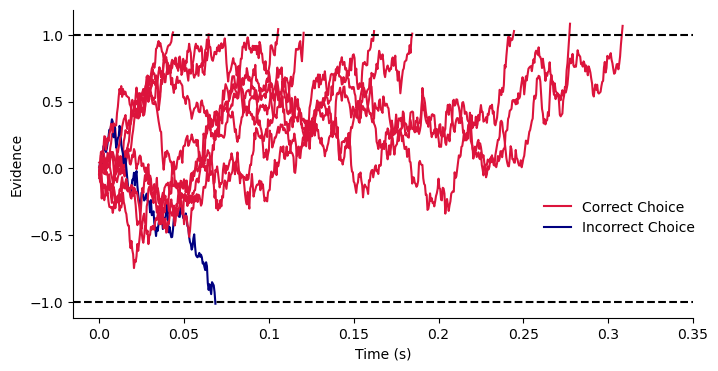

In [3]:
# Set a random seed
np.random.seed(1312)

# Set parameters
C0, v, dt, w, B = 0., 2.5, 5e-4, .05, 1.

# Loop through 1000 runs of the model:
n_runs = 1000
evidences = []
decision_vars = []
run_lengths = []
for run in range(n_runs):
    decision, length, evidence = ddm(C0, v, dt, w, B)
    evidences.append(evidence)
    decision_vars.append(decision)
    run_lengths.append(length*dt)
# Plot first e.g. 10 model runs:
n_plot_runs = 10
fig, ax = plt.subplots(figsize=(8,4))
colors = ["crimson", "navy"]
for i in range(n_plot_runs):
    ax.plot(evidences[i], color=colors[0] if decision_vars[i] > 0 else colors[1])
ax.plot(0,0, color="crimson", label="Correct Choice")
ax.plot(0,0, color="navy", label="Incorrect Choice")
ax.set(xlabel="Time (s)", ylabel="Evidence")
ax.set_xticks(ax.get_xticks()[1:], np.round(ax.get_xticks()*dt, 3)[1:])
ax.axhline(1 ,ls='--', color='k')
ax.axhline(-1, ls='--', color='k')
#ax.axhline(0, ls='--', color='k')
ax.legend(loc=[0.75, 0.25], frameon=False)
sns.despine();

The model makes the wrong decision at times because the noise term can be negative and dominate the drift term. Since the noise is drawn from a normalized Gaussian, it takes on negative values 50% of the time and the drift term is multiplied by a small time scale factor $dt$ that can make it small in magnitude compared to the noise. The drift will then never compensate for the negative noise samples and we reach the $-B$ boundary. 

Plot the proportion of runs that ended in correct and incorrect choices (e.g. a simple bar plot).

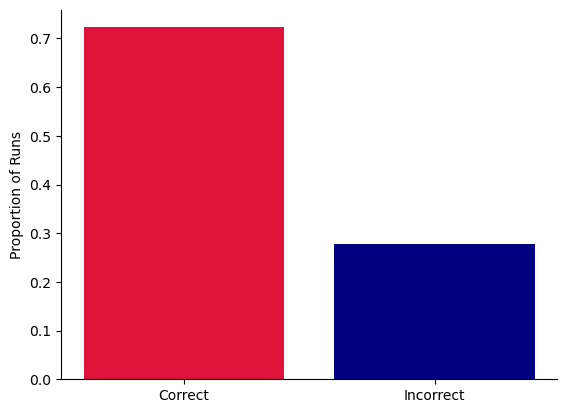

In [4]:
# Plot the proportion of correct and incorrect choices:
n_correct = np.mean(np.array(decision_vars) > 0)
n_wrong = 1 - n_correct
plt.bar([0.5, 1.5], [n_correct, n_wrong], color=colors)
plt.xticks([0.5, 1.5], ["Correct", "Incorrect"])
plt.ylabel("Proportion of Runs")
sns.despine();

Plot the two distributions of reaction times (RTs; e.g. using `sns.histplot` or `sns.kdeplot`) for correct and incorrect trials. (You may want to convert the reaction times and outcomes to a `pandas` `DataFrame` before plotting with `seaborn`.) Report the mean and median of these distributions. Are they symmetric or skewed?

/usr/people/sa5437/miniconda3/envs/neu502b/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


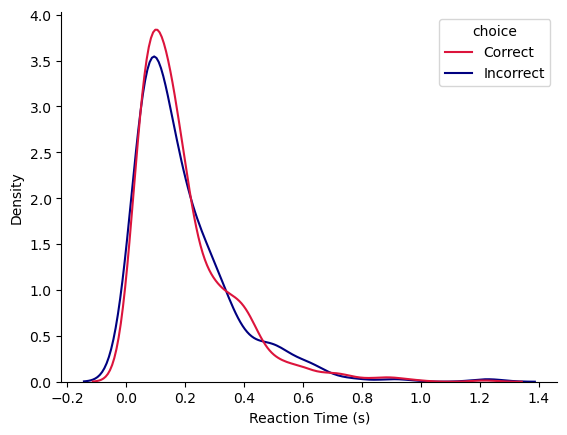

In [5]:
# Plot RT distributions of correct and incorrect trials:
data_dict = {
    "rt": np.array(run_lengths),
    "choice": ["Correct" if x > 0 else "Incorrect" for x in decision_vars]
}
palette = {
    "Incorrect":"navy",
    "Correct":"crimson"
}
df = pd.DataFrame(data_dict)
sns.kdeplot(data=df, x="rt", hue="choice", palette=palette, common_norm=False)
plt.xlabel("Reaction Time (s)")
sns.despine();

In [6]:
from scipy.stats import skew

# Report the mean, median, and skew:
means = df.groupby(["choice"]).mean()
meds = df.groupby(["choice"]).median()
skews = df.groupby(["choice"]).skew()

print(f"Mean RT for Correct Responses: {means['rt'].iloc[0]} s" 
     "\n" f"Mean RT for Incorrect Responses: {means['rt'].iloc[1]} s"
     "\n" f"Median RT for Correct Responses: {meds['rt'].iloc[0]} s"
     "\n" f"Median RT for Incorrect Responses: {meds['rt'].iloc[1]} s"
     "\n" f"Skew for Correct Responses: {skews['rt'].iloc[0]}"
     "\n" f"Skew for Incorrect Responses: {skews['rt'].iloc[1]}")

Mean RT for Correct Responses: 0.19470677731673583 s
Mean RT for Incorrect Responses: 0.19392960288808664 s
Median RT for Correct Responses: 0.1485 s
Median RT for Incorrect Responses: 0.145 s
Skew for Correct Responses: 1.9650129418929576
Skew for Incorrect Responses: 2.0977190724971972


Both distributions have similar means, medians, and skews. From the quantitative data and similar shapes of distributions, we can deduce that they are symmetric.

### Problem 2: Varying sensory evidence
Now that we have a grasp on how the drift-diffusion model behaves, let's start varying the input. Start with the previous model with evidence $v$ = 2.5, then run two additional models with increased $2 \times v$ evidence and decreased $.5 \times v$ evidence. As in the previous exercises, plot a few model runs, the proportion of correct and incorrect trials, and the reaction time distributions for all three levels of sensory evidence (baseline, increased, and decreased). How do these different amounts of sensory evidence affect the decision process?

In [7]:
# Set a random seed
np.random.seed(1312)

# Set up different evidence levels
n_iters = 1000
C0, dt, w, B = 0., 5e-4, .05, 1.
v_base = 2.5
vs = [v_base, v * 2, v * .5]
labels = ['baseline', 'increased', 'decreased']

# Run models and plot for three evidence levels:
# Running
def run_ddm(n_iters, C0, v, dt, w, B):
    """Runs drift diffusion model.

    Args:
        n_iters: number of runs
        ddm_kwargs: C0, dt, w, B

    Returns:
        evidences: Array of length n_iters
        decision_vars: Array of length n_iters
        rts: Array of length n_iters
    """
    evidences = []
    decision_vars = []
    rts = []

    for epoch in range(n_iters):
        decision, length, evidence = ddm(C0, v, dt, w, B)
        evidences.append(evidence)
        decision_vars.append(decision)
        rts.append(length*dt)

    return evidences, decision_vars, rts

evidences_baseline, dvars_baseline, rts_baseline = run_ddm(n_iters, C0, vs[0], dt, w, B)
evidences_increased, dvars_increased, rts_increased = run_ddm(n_iters, C0, vs[1], dt, w, B)
evidences_decreased, dvars_decreased, rts_decreased = run_ddm(n_iters, C0, vs[2], dt, w, B)

all_evidences = [evidences_baseline, evidences_increased, evidences_decreased]
all_dvars = [dvars_baseline, dvars_increased, dvars_decreased]
all_rts = [rts_baseline, rts_increased, rts_decreased]

all_data_dicts = [
    {"rt": np.array(all_rts[i]), "choice":["Correct" if x > 0 else "Incorrect" for x in all_dvars[i]]} 
    for i in range(len(vs))
]
all_dfs = [pd.DataFrame(x) for x in all_data_dicts]

/usr/people/sa5437/miniconda3/envs/neu502b/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/people/sa5437/miniconda3/envs/neu502b/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/usr/people/sa5437/miniconda3/envs/neu502b/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.optio

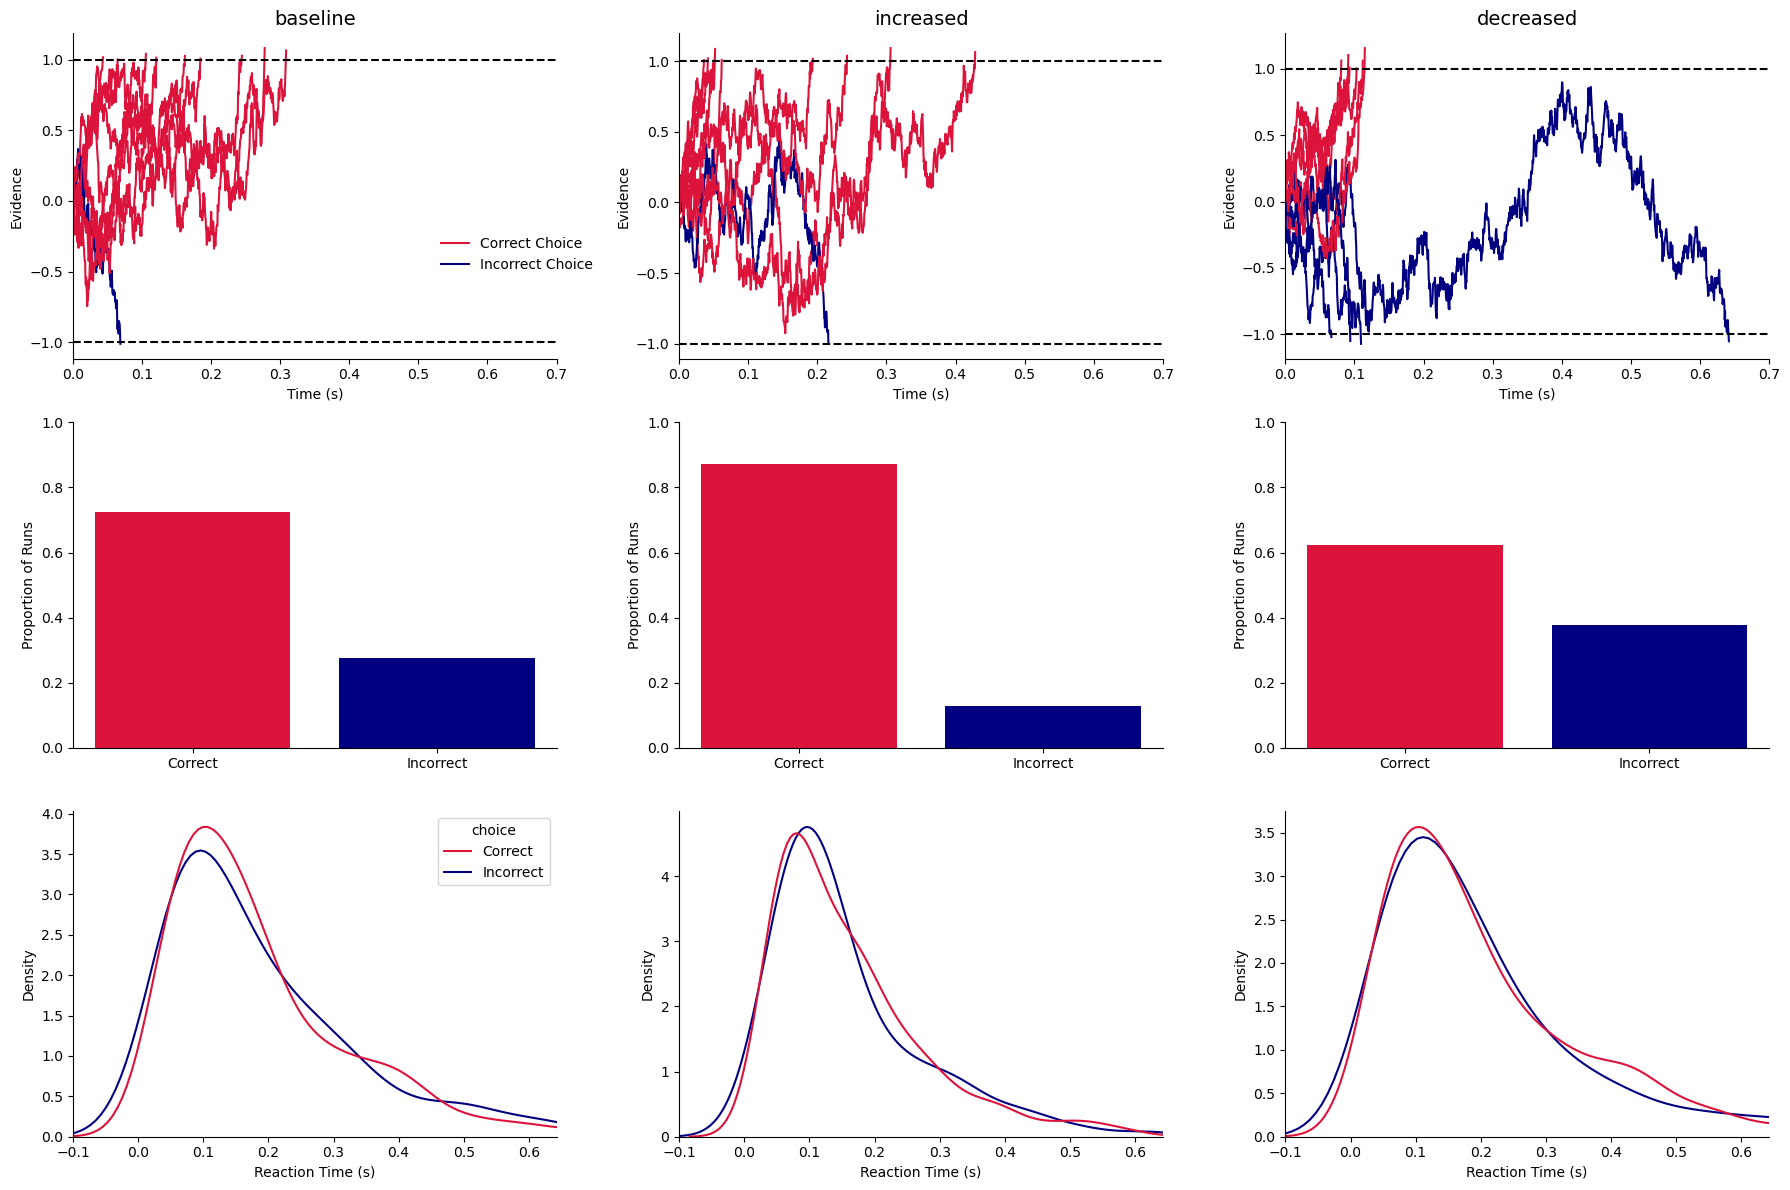

In [8]:
# Plotting 
n_plot_runs = 10
fig, axs = plt.subplots(3,3,figsize=(18,12), facecolor="w", tight_layout=True)
xrange = ([0, np.max([np.max(x[:n_plot_runs]) for x in all_rts]) / dt])
for i in range(len(vs)):
    for j in range(len(vs)):
        if i == 0:
            for k in range(n_plot_runs):
                axs[i,j].plot(all_evidences[j][k], color=colors[0] if all_dvars[j][k] > 0 else colors[1])
            axs[i,j].plot(0,0, color="crimson", label="Correct Choice")
            axs[i,j].plot(0,0, color="navy", label="Incorrect Choice")
            axs[i,j].set(xlabel="Time (s)", ylabel="Evidence")
            axs[i,j].axhline(1 ,ls='--', color='k')
            axs[i,j].axhline(-1, ls='--', color='k')
            axs[i,j].set_xlim(xrange)
            axs[i,j].set_xticks(axs[i,j].get_xticks(), np.round(axs[i,j].get_xticks()*dt, 3))
            if j == 0:
                axs[i,j].legend(loc=[0.75, 0.25], frameon=False)
            axs[i,j].set_title(labels[j], fontsize=14)
            sns.despine(fig=fig, ax=axs[i,j])
        if i == 1:
            n_correct = np.mean(np.array(all_dvars[j]) > 0)
            n_wrong = 1 - n_correct
            axs[i,j].bar([0.5, 1.5], [n_correct, n_wrong], color=colors)
            axs[i,j].set_xticks([0.5, 1.5], ["Correct", "Incorrect"])
            axs[i,j].set_ylabel("Proportion of Runs")
            axs[i,j].set_ylim([0.0, 1.0])
            sns.despine(fig=fig, ax=axs[i,j])
        if i == 2:
            sns.kdeplot(data=all_dfs[j], x="rt", hue="choice", palette=palette, ax=axs[i,j], common_norm=False)
            axs[i,j].set_xlabel("Reaction Time (s)")
            axs[i,j].set_xlim([-0.1, xrange[1]*dt])
            sns.despine(fig=fig, ax=axs[i,j])
            if j != 0:
                axs[i,j].legend().remove()

We see that increasing the value of sensory evidence both increases the proportion of runs where the model makes the correct decision and also reduces the average time it takes for the model to arrive at a correct decision. This is because the increased evidence term in the update equation dominates the noise term and we approach the decision boundaries at a faster rate. Conversely, decreasing the value of sensory information decreases the proportion of correct runs and increases the average time it takes for the model to converge to the correct decision.

### Problem 3: Speed-accuracy tradeoff
Subjects appear to be able to trade accuracy for speed in most perceptual decision-making tasks. The drift-diffusion model can capture this tradeoff in a relatively simple way. Describe how you might model this speed-accuracy tradeoff. Using a fixed sensory evidence $v$ = 2.5, run three different versions of the model: the baseline model from previous exercises, an "accuracy"-biased model, and a "speed"-biased model. As in the previous exercise, plot a few model runs, the proportion of correct and incorrect trials, and the reaction time distributions for all three models (baseline, accuracy, and speed).

We can model the speed-accuracy tradeoff by manipulating the evidence boundaries. For more accurate models, we will need higher thresholds and for faster models we will need lower thresholds. We need higher boundaries for more accurate models because they will require the accumulation of more evidence. Conversely, models with lower boundaries will require less evidence to converge and reach convergence in fewer time steps. 

/usr/people/sa5437/miniconda3/envs/neu502b/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/people/sa5437/miniconda3/envs/neu502b/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/usr/people/sa5437/miniconda3/envs/neu502b/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.optio

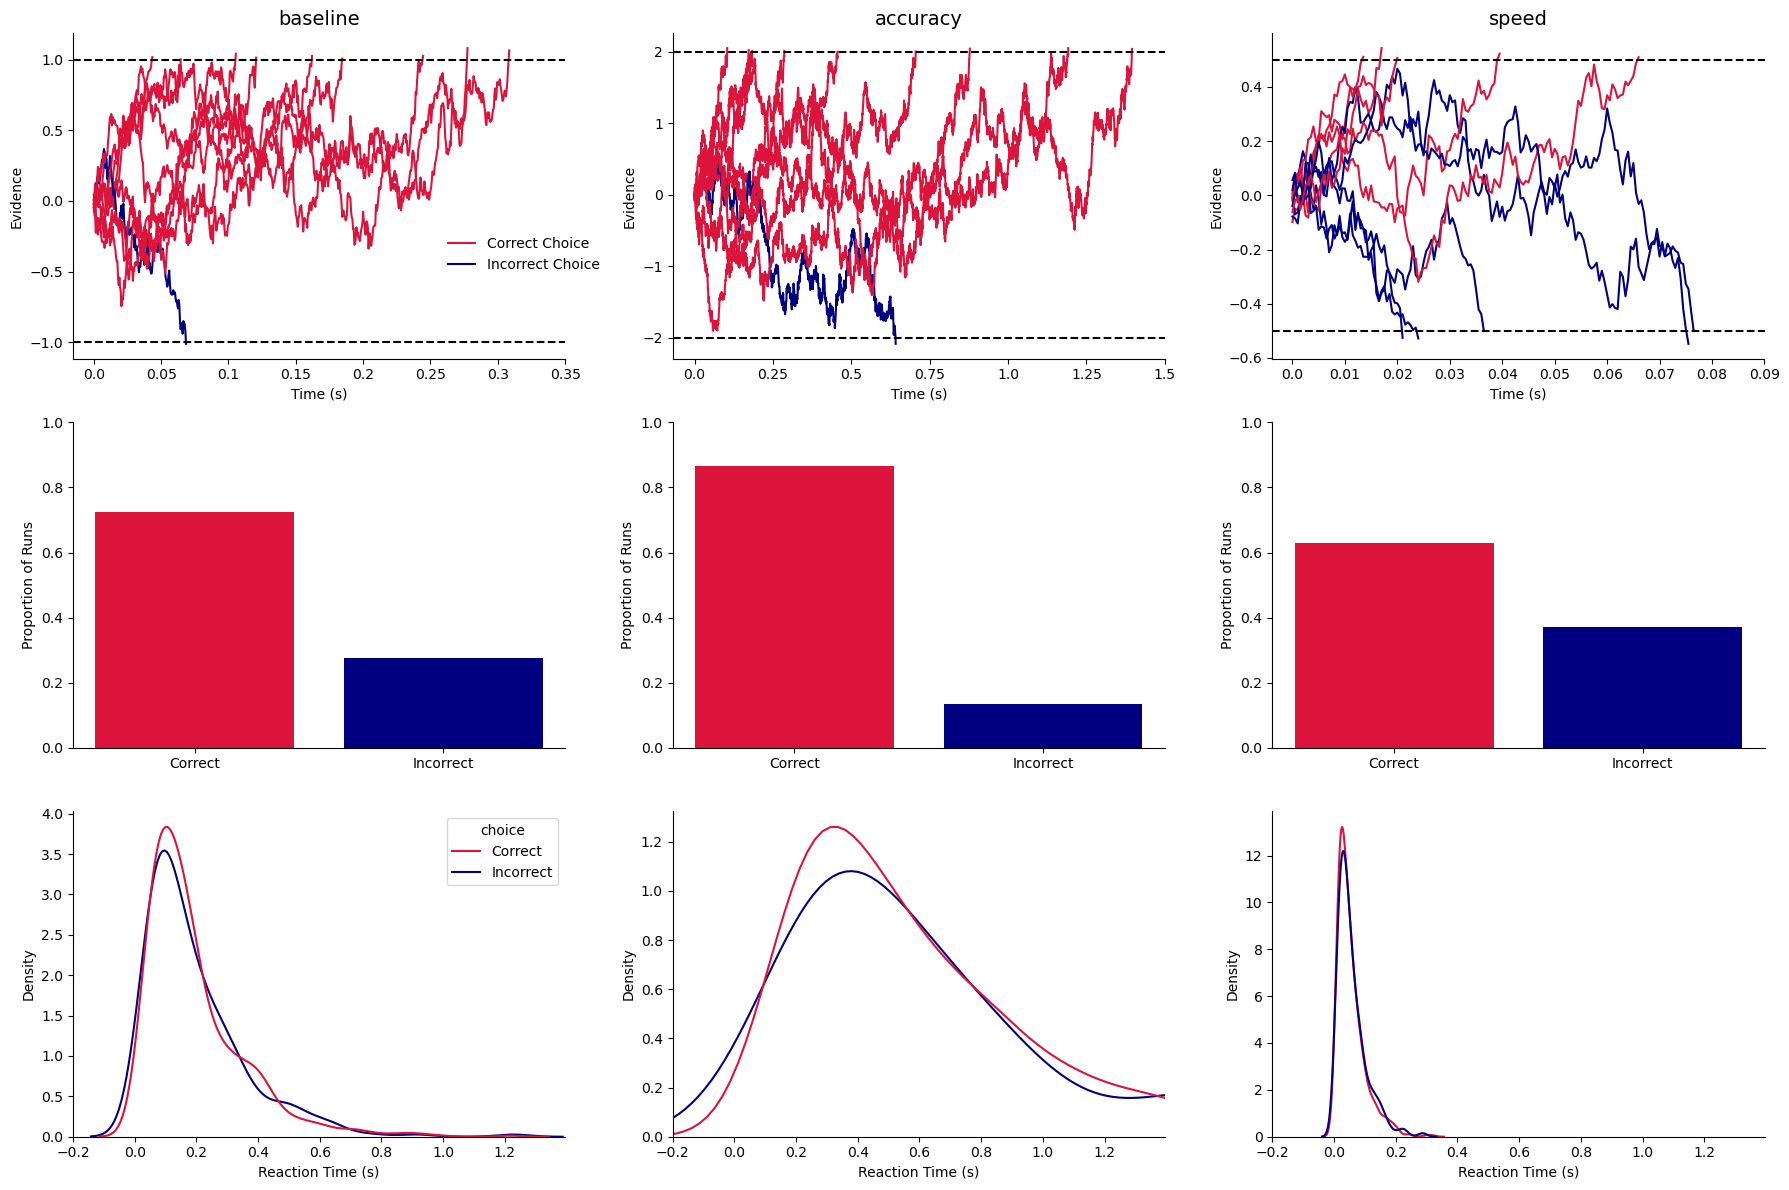

In [9]:
# Set a random seed
np.random.seed(1312)

# Set up different models:
n_iters = 1000
C0, v, dt, w = 0., 2.5, 5e-4, .05
B_base = 1.0
Bs = [B_base, B_base * 2, B_base * .5]
labels = ['baseline', 'accuracy', 'speed']

# Run models and plot for three evidence levels:
evidences_baseline, dvars_baseline, rts_baseline = run_ddm(n_iters, C0, v, dt, w, Bs[0])
evidences_acc, dvars_acc, rts_acc = run_ddm(n_iters, C0, v, dt, w, Bs[1])
evidences_speed, dvars_speed, rts_speed = run_ddm(n_iters, C0, v, dt, w, Bs[2])

all_evidences = [evidences_baseline, evidences_acc, evidences_speed]
all_dvars = [dvars_baseline, dvars_acc, dvars_speed]
all_rts = [rts_baseline, rts_acc, rts_speed]

all_data_dicts = [
    {"rt": np.array(all_rts[i]), "choice":["Correct" if x > 0 else "Incorrect" for x in all_dvars[i]]} 
    for i in range(len(vs))
]
all_dfs = [pd.DataFrame(x) for x in all_data_dicts]

# Plotting 
n_plot_runs = 10
xrange = ([0, np.max([np.max(x[:n_plot_runs]) for x in all_rts]) / dt])
fig, axs = plt.subplots(3,3,figsize=(18,12), facecolor="w", tight_layout=True)
for i in range(len(vs)):
    for j in range(len(vs)):
        if i == 0:
            for k in range(n_plot_runs):
                axs[i,j].plot(all_evidences[j][k], color=colors[0] if all_dvars[j][k] > 0 else colors[1])
            axs[i,j].plot(0,0, color="crimson", label="Correct Choice")
            axs[i,j].plot(0,0, color="navy", label="Incorrect Choice")
            axs[i,j].set(xlabel="Time (s)", ylabel="Evidence")
            axs[i,j].axhline(Bs[j] ,ls='--', color='k')
            axs[i,j].axhline(-Bs[j], ls='--', color='k')
            #axs[i,j].set_xlim(xrange)
            axs[i,j].set_xticks(axs[i,j].get_xticks()[1:], np.round(axs[i,j].get_xticks()*dt, 3)[1:])
            if j == 0:
                axs[i,j].legend(loc=[0.75, 0.25], frameon=False)
            axs[i,j].set_title(labels[j], fontsize=14)
            sns.despine(fig=fig, ax=axs[i,j])
        if i == 1:
            n_correct = np.mean(np.array(all_dvars[j]) > 0)
            n_wrong = 1 - n_correct
            axs[i,j].bar([0.5, 1.5], [n_correct, n_wrong], color=colors)
            axs[i,j].set_xticks([0.5, 1.5], ["Correct", "Incorrect"])
            axs[i,j].set_ylabel("Proportion of Runs")
            axs[i,j].set_ylim([0.0, 1.0])
            sns.despine(fig=fig, ax=axs[i,j])
        if i == 2:
            sns.kdeplot(data=all_dfs[j], x="rt", hue="choice", palette=palette, ax=axs[i,j], common_norm=False)
            axs[i,j].set_xlabel("Reaction Time (s)")
            axs[i,j].set_xlim([-0.2, xrange[1]*dt])
            sns.despine(fig=fig, ax=axs[i,j])
            if j != 0:
                axs[i,j].legend().remove()

### Problem 4: Trial-by-trial sensory variability
In the original "baseline" model, we see that the reaction time distributions for correct and incorrect trials are largely overlapping. However, in experiments, reaction times for incorrect trials are typically longer than for correct trials. To capture this effect, let's add some trial-by-trial variability: instead of a fixed $v$ for all trials, allow $v$ to vary across trials according to a normal distribution $v = 2.5 + \mathcal{N}(0,5)$. Report the mean, median, and skew as in Problem 1.

/usr/people/sa5437/miniconda3/envs/neu502b/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


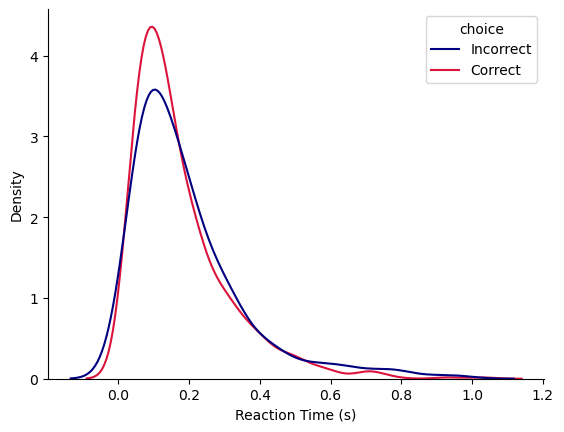

In [10]:
# Set a random seed
np.random.seed(1312)
# Run models with trial-by-trial variability:
n_trials = 1000
C0, v, dt, w, B = 0., 2.5, 5e-4, .05, 1.
vs = 2.5 + np.random.normal(loc=0.0, scale=np.sqrt(5.0), size=n_trials)

evidences = []
decision_vars = []
run_lengths = []
for run in range(n_trials):
    decision, length, evidence = ddm(C0, vs[run], dt, w, B)
    evidences.append(evidence)
    decision_vars.append(decision)
    run_lengths.append(length * dt)
# Plot RT distributions of correct and incorrect trials:
data_dict = {
    "rt": np.array(run_lengths),
    "choice": ["Correct" if x > 0 else "Incorrect" for x in decision_vars]
}
palette = {
    "Incorrect":"navy",
    "Correct":"crimson"
}
df = pd.DataFrame(data_dict)
sns.kdeplot(data=df, x="rt", hue="choice", palette=palette, common_norm=False)
plt.xlabel("Reaction Time (s)")
sns.despine();

In [11]:
# Report the mean, median, and skew:
means = df.groupby(["choice"]).mean()
meds = df.groupby(["choice"]).median()
skews = df.groupby(["choice"]).skew()

print(f"Mean RT for Correct Responses: {means['rt'].iloc[0]} ms" 
     "\n" f"Mean RT for Incorrect Responses: {means['rt'].iloc[1]} ms"
     "\n" f"Median RT for Correct Responses: {meds['rt'].iloc[0]} ms"
     "\n" f"Median RT for Incorrect Responses: {meds['rt'].iloc[1]} ms"
     "\n" f"Skew for Correct Responses: {skews['rt'].iloc[0]}"
     "\n" f"Skew for Incorrect Responses: {skews['rt'].iloc[1]}")

Mean RT for Correct Responses: 0.17545630372492838 ms
Mean RT for Incorrect Responses: 0.19467549668874173 ms
Median RT for Correct Responses: 0.13425 ms
Median RT for Incorrect Responses: 0.1525 ms
Skew for Correct Responses: 1.9147500095692498
Skew for Incorrect Responses: 1.952203879104036
